# Import

In [75]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import spacy
import re
from collections import Counter
import matplotlib.pyplot as plt
from gensim import corpora, models
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /Users/marco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [76]:
customers_df = pd.read_csv('/Users/marco/Documents/python_projects/churn_bcgx/data/customers.csv')
complaints_df = pd.read_csv('/Users/marco/Documents/python_projects/churn_bcgx/data/complaints.csv', encoding='utf-8')

# TODO: fix column types. E.g.:
customers_df['Churn'] = customers_df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0).astype(np.int8)

aug_customers_df = pd.merge(customers_df, complaints_df, on='customerID', how='left')
complaints_text = complaints_df[~complaints_df['complaint'].isna()]['complaint'].values

# Analysis

## Stand-alone w/o customer data

In [77]:
# Initialize spacy
nlp = spacy.load('en_core_web_sm')

# Text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()

    # Handle contractions first (before removing special characters)
    text = text.replace("'m", " am")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'s", " is")
    text = text.replace("'ll", " will")
    text = text.replace("'ve", " have")
    text = text.replace("'d", " would")

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    doc = nlp(text)
    # Remove stopwords and lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Process all complaints
processed_complaints = [preprocess_text(text) for text in complaints_text]

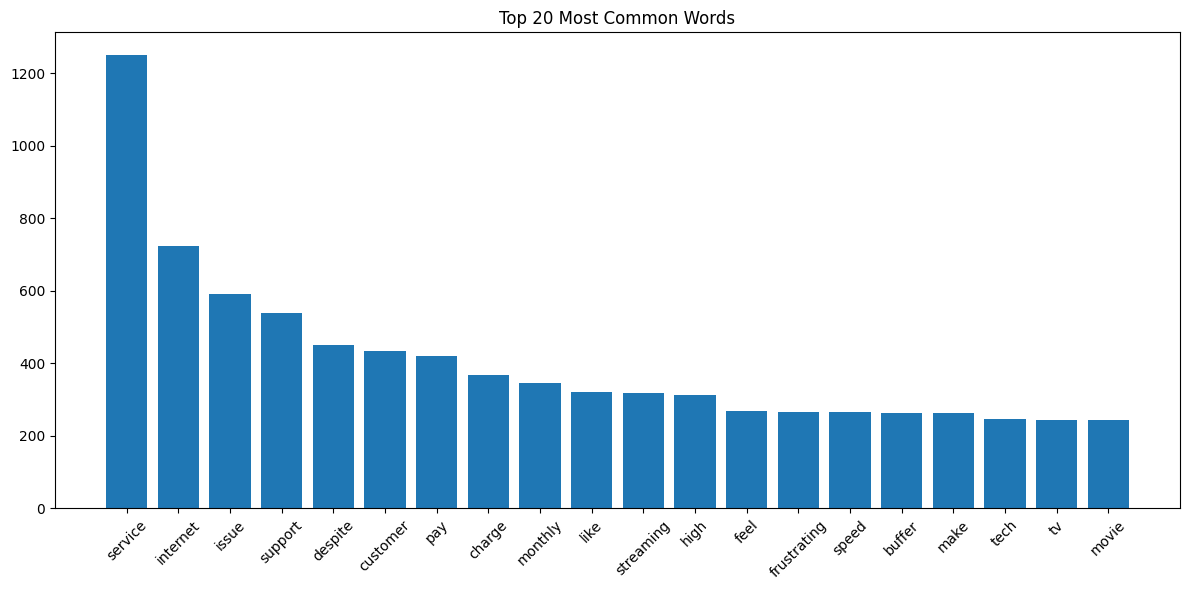

Average complaint length: 14.41 words
Number of unique words: 856


In [78]:
# Word frequency analysis
all_words = ' '.join(processed_complaints).split()
word_freq = Counter(all_words)

# Plot top 20 words
plt.figure(figsize=(12, 6))
top_20 = dict(word_freq.most_common(20))
plt.bar(top_20.keys(), top_20.values())
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words')
plt.tight_layout()
plt.show()

# Basic statistics
avg_length = np.mean([len(text.split()) for text in processed_complaints])
unique_words = len(set(all_words))
print(f"Average complaint length: {avg_length:.2f} words")
print(f"Number of unique words: {unique_words}")

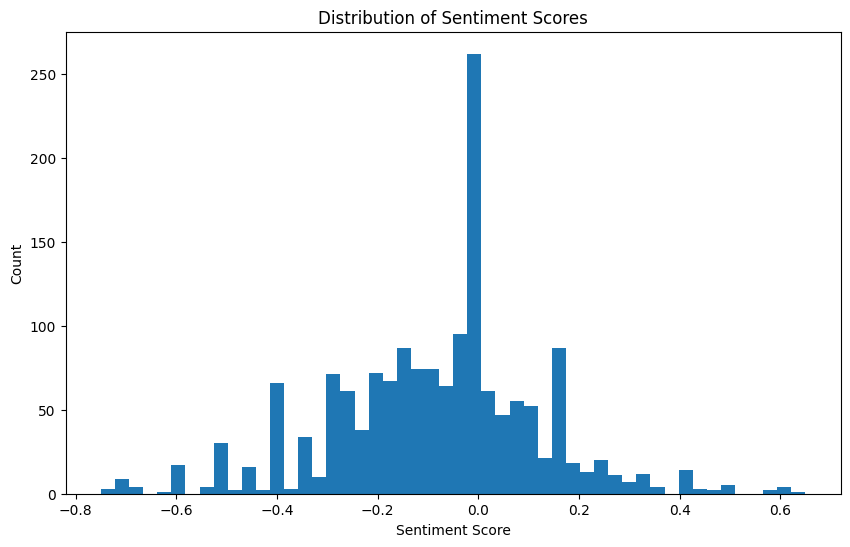

Average sentiment score: -0.083


In [79]:
# Calculate sentiment scores
sentiment_scores = [TextBlob(text).sentiment.polarity for text in processed_complaints]

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
plt.hist(sentiment_scores, bins=50)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

# Calculate average sentiment
avg_sentiment = np.mean(sentiment_scores)
print(f"Average sentiment score: {avg_sentiment:.3f}")

In [80]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(processed_complaints)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Add sentiment scores
tfidf_df['sentiment_score'] = sentiment_scores

# Add text length
tfidf_df['text_length'] = [len(text.split()) for text in processed_complaints]

# Display first few rows
print(tfidf_df.head())

   assistance  available  basic  bill  billing    buffer  buffering  call  \
0    0.000000        0.0    0.0   0.0      0.0  0.235060        0.0   0.0   
1    0.000000        0.0    0.0   0.0      0.0  0.000000        0.0   0.0   
2    0.000000        0.0    0.0   0.0      0.0  0.384424        0.0   0.0   
3    0.370898        0.0    0.0   0.0      0.0  0.000000        0.0   0.0   
4    0.000000        0.0    0.0   0.0      0.0  0.000000        0.0   0.0   

     charge  complete  ...  unreliable  use  value   ve     watch  well  work  \
0  0.212155  0.000000  ...         0.0  0.0    0.0  0.0  0.341623   0.0   0.0   
1  0.000000  0.369386  ...         0.0  0.0    0.0  0.0  0.000000   0.0   0.0   
2  0.000000  0.000000  ...         0.0  0.0    0.0  0.0  0.000000   0.0   0.0   
3  0.000000  0.000000  ...         0.0  0.0    0.0  0.0  0.000000   0.0   0.0   
4  0.000000  0.000000  ...         0.0  0.0    0.0  0.0  0.000000   0.0   0.0   

   year  sentiment_score  text_length  
0   0.0   

## With customer data

In [81]:
# Create a DataFrame with complaints and churn status
complaints_analysis = aug_customers_df[['customerID', 'complaint', 'Churn']].copy()

# Add processed complaints
complaints_analysis['processed_complaint'] = complaints_analysis['complaint'].apply(preprocess_text)

# Add basic text features
complaints_analysis['complaint_length'] = complaints_analysis['complaint'].fillna('').str.len()
complaints_analysis['has_complaint'] = complaints_analysis['complaint'].notna()
complaints_analysis['sentiment'] = complaints_analysis['complaint'].fillna('').apply(lambda x: TextBlob(str(x)).sentiment.polarity)

Statistics by Churn Status:
       has_complaint  complaint_length  sentiment
Churn                                            
0              0.111            18.979     -0.003
1              0.407            68.873     -0.035


<Figure size 1000x500 with 0 Axes>

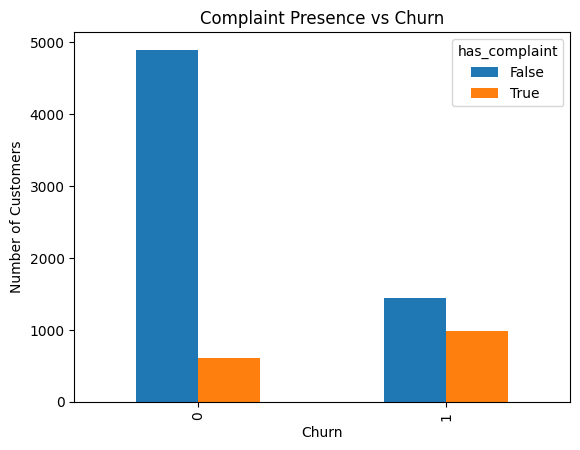

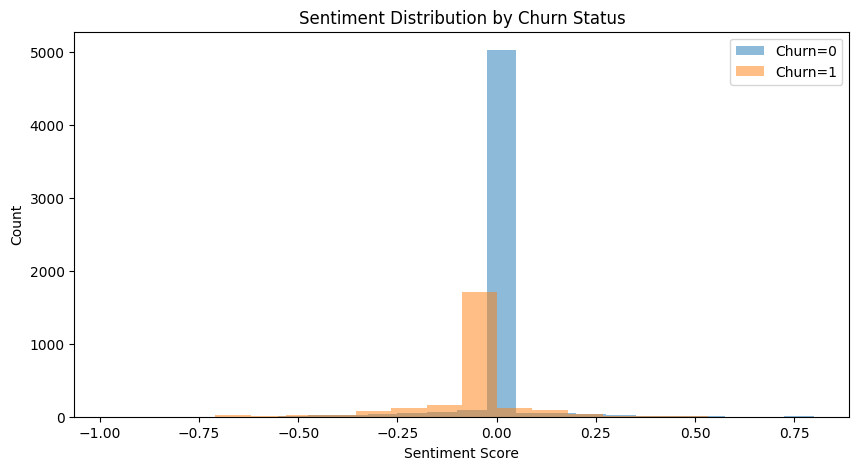

In [83]:
# Basic statistics by churn status
churn_stats = complaints_analysis.groupby('Churn').agg({
    'has_complaint': 'mean',
    'complaint_length': 'mean',
    'sentiment': 'mean'
}).round(3)

print("Statistics by Churn Status:")
print(churn_stats)

# Visualize complaint presence vs churn
plt.figure(figsize=(10, 5))
complaints_analysis.groupby(['Churn', 'has_complaint']).size().unstack().plot(kind='bar')
plt.title('Complaint Presence vs Churn')
plt.ylabel('Number of Customers')
plt.show()

# Sentiment distribution by churn status
plt.figure(figsize=(10, 5))
for churn in [0, 1]:
    plt.hist(complaints_analysis[complaints_analysis['Churn'] == churn]['sentiment'].values, 
             alpha=0.5, 
             label=f'Churn={churn}',
             bins=20)
plt.title('Sentiment Distribution by Churn Status')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend()
plt.show()

In [102]:
aug_customers_df.groupby('Churn')['complaint'].count()/aug_customers_df.groupby('Churn')['customerID'].count()

Churn
0    0.111454
1    0.406982
dtype: float64

In [95]:
# Function to get top unique words by POS for a specific group
def get_unique_top_words_by_pos(churned_complaints, non_churned_complaints, n=10, pos_types=None):
    if pos_types is None:
        pos_types = ['NOUN', 'VERB', 'ADJ', 'ADV']
    
    # Process each group
    def process_group(complaints):
        text = ' '.join(complaints.dropna())
        doc = nlp(text)
        pos_dict = {pos: Counter() for pos in pos_types}
        for token in doc:
            if token.pos_ in pos_dict:
                pos_dict[token.pos_][token.lemma_] += 1
        return pos_dict
    
    churned_pos = process_group(churned_complaints)
    non_churned_pos = process_group(non_churned_complaints)
    
    # Find unique words for each group
    unique_words = {}
    for pos in pos_types:
        churned_set = set(dict(churned_pos[pos].most_common(n*2)))  # Get more words initially
        non_churned_set = set(dict(non_churned_pos[pos].most_common(n*2)))
        
        # Get words unique to each group
        unique_churned = [(word, churned_pos[pos][word]) 
                         for word in (churned_set - non_churned_set)]
        unique_non_churned = [(word, non_churned_pos[pos][word]) 
                            for word in (non_churned_set - churned_set)]
        
        # Sort by count and take top n
        unique_words[pos] = {
            'churned': sorted(unique_churned, key=lambda x: x[1], reverse=True)[:n],
            'non_churned': sorted(unique_non_churned, key=lambda x: x[1], reverse=True)[:n]
        }
    
    return unique_words

# Get unique top words
TOP_N = 20  # Easy to modify number of top words
POS_TYPES = ['NOUN', 'VERB', 'ADJ', 'ADV']  # Easy to modify POS types

unique_words = get_unique_top_words_by_pos(
    complaints_analysis[complaints_analysis['Churn'] == 1]['processed_complaint'],
    complaints_analysis[complaints_analysis['Churn'] == 0]['processed_complaint'],
    n=TOP_N,
    pos_types=POS_TYPES
)

# Print results in a clean format
for pos in POS_TYPES:
    print(f"\n=== {pos} ===")
    print("\nChurned customers unique words:")
    for word, count in unique_words[pos]['churned']:
        print(f"{word}: {count}")
    
    print("\nNon-churned customers unique words:")
    for word, count in unique_words[pos]['non_churned']:
        print(f"{word}: {count}")


=== NOUN ===

Churned customers unique words:
contact: 97
outage: 86
month: 63
task: 58
value: 57
problem: 57
use: 48
load: 39
performance: 38

Non-churned customers unique words:
year: 52
payment: 41
hour: 39
billing: 37
bill: 35
drop: 35
longterm: 33
watch: 32
inconsistent: 32

=== VERB ===

Churned customers unique words:
leave: 42
remain: 29
cancel: 25
decide: 23
slow: 15
keep: 15
call: 14
support: 13
charge: 12
fail: 11
lack: 11
meet: 10
sign: 10

Non-churned customers unique words:
wait: 20
offer: 19
have: 18
happen: 16
affect: 15
understand: 13
prefer: 12
freeze: 12
increase: 10
add: 10
notice: 10
know: 8
browse: 7

=== ADJ ===

Churned customers unique words:
unreliable: 125
frustrated: 33
disappointing: 26
unresolved: 23
proper: 17
constant: 17
electronic: 12
complicated: 11
dissatisfied: 11

Non-churned customers unique words:
stable: 21
detailed: 13
reliable: 12
unhappy: 11
consistent: 10
new: 9
backup: 8
inconvenient: 8
current: 8

=== ADV ===

Churned customers unique wor

In [86]:
from scipy import stats

# Test if sentiment differs between churned and non-churned customers
churn_sentiment = complaints_analysis[complaints_analysis['Churn'] == 1]['sentiment'].dropna()
non_churn_sentiment = complaints_analysis[complaints_analysis['Churn'] == 0]['sentiment'].dropna()
t_stat, p_value = stats.ttest_ind(churn_sentiment, non_churn_sentiment)

print("\nSentiment T-Test Results:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")

# Chi-square test for complaint presence vs churn
contingency = pd.crosstab(complaints_analysis['Churn'], complaints_analysis['has_complaint'])
chi2, p_value = stats.chi2_contingency(contingency)[:2]

print("\nChi-square Test Results (Complaint Presence vs Churn):")
print(f"chi-square statistic: {chi2:.3f}")
print(f"p-value: {p_value:.3f}")


Sentiment T-Test Results:
t-statistic: -13.253
p-value: 0.000

Chi-square Test Results (Complaint Presence vs Churn):
chi-square statistic: 912.936
p-value: 0.000


# Notes for call

## Data Processing
- extract from Excel specifying CSV UTF-8 type
- preprocessing text with replacement of contractions
- need to convert all columns to correct data types
- apply heavy processing to focus on meaning: lower, replace, remove special characters and numbers, remove stopwords, lemmasation.

## Data analysis standalone
- sentiment analysis
– topic analysis no because doc are too short and word position does matter

## Data analysis with customer data
- different in sentiment between churn and not churn
- imbalance: complaint rate in churn customers higher: 11% vs 41%
- most words grouped by churned or not churned and POS. like in TF-IDF, look for words that discriminate well, i.e. that occur a lot only in one user category. interesting with adjectives. 
- sentiment analysis, statistically significant difference between two groups.
- statistically significance of complaint presence on churn. 

## Semi-Supervised Learning with Synthetic Data Generation

